In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.contrib.eager as tfe
#from ADMM import ADMM_NN
from tensorflow.examples.tutorials.mnist import input_data

tfe.enable_eager_execution()

mnist = input_data.read_data_sets("./data/", one_hot=True)

trainX = np.transpose(mnist.train.images).astype(np.float32)
trainY = np.transpose(mnist.train.labels).astype(np.float32)

validX = np.transpose(mnist.validation.images).astype(np.float32)
validY = np.transpose(mnist.validation.labels).astype(np.float32)

testX = np.transpose(mnist.test.images).astype(np.float32)
testY = np.transpose(mnist.test.labels).astype(np.float32)

/Users/sichenglei/Desktop/kaggle/salt/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)

Bad key "ckend" on line 1 in
/Users/sichenglei/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/Users/sichenglei/Desktop/kaggle/salt/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
## Codes adapted from: https://github.com/PotatoThanh/ADMM-NeuralNetworks/tree/master/python
class ADMM_NN(object):
    def __init__(self, n_inputs, n_hiddens, n_outputs, n_batches, n_layers):
        """
        Initialize variables for NN.
        Not sure how initialization affects the performance.
        The data should be in columns.
        for example, the input size of MNIST data should be (28x28, *) instead of (*, 28x28).
        Ignored bias terms.
        :param n_inputs: Number of inputs.
        :param n_hiddens: Number of hidden units.
        :param n_outputs: Number of outputs
        :param n_batches: Number of data sample that you want to train
        :param n_layers: Number of hidden layers
        """
        self.layers = n_layers
        self.a0 = np.zeros((n_inputs, n_batches))

        self.wi = np.zeros((n_hiddens, n_inputs))
#         self.w2 = np.zeros((n_hiddens, n_hiddens))
        self.wf = np.zeros((n_outputs, n_hiddens))

        self.z = []
        self.a = []
        self.wh = []
        
        ## note that the index starts form 0 so z[0] would be z_1
        for n in range(n_layers):
            self.z.append(np.random.rand(n_hiddens, n_batches))
            self.a.append(np.random.rand(n_hiddens, n_batches))
            if n < n_layers-1:
                self.wh.append(np.zeros((n_hiddens, n_hiddens)))
        
#         self.z1 = np.random.rand(n_hiddens, n_batches)
#         self.a1 = np.random.rand(n_hiddens, n_batches)

#         self.z2 = np.random.rand(n_hiddens, n_batches)
#         self.a2 = np.random.rand(n_hiddens, n_batches)

        self.zL = np.random.rand(n_outputs, n_batches)

        self.lambda_lagrange = np.ones((n_outputs, n_batches))

    def _relu(self, x):
        return tf.maximum(0.0, x)

    def _weight_update(self, layer_output, activation_input):
        """
        Consider it now the minimization of the problem with respect to W_l.
        For each layer l, the optimal solution minimizes ||z_l - W_l a_l-1||^2. This is simply
        a least square problem, and the solution is given by W_l = z_l p_l-1, where p_l-1
        represents the pseudo-inverse of the rectangular activation matrix a_l-1.
        :param layer_output: output matrix (z_l)
        :param activation_input: activation matrix l-1  (a_l-1)
        :return: weight matrix
        """
        pinv = np.linalg.pinv(activation_input)
        weight_matrix = tf.matmul(tf.cast(layer_output, tf.float32), tf.cast(pinv, tf.float32))
        return weight_matrix 

    def _activation_update(self, next_weight, next_layer_output, layer_nl_output, beta, gamma):
        """
        Minimization for a_l is a simple least squares problem similar to the weight update.
        However, in this case the matrix appears in two penalty terms in the problem, and so
        we must minimize:
            beta ||z_l+1 - W_l+1 a_l||^2 + gamma ||a_l - h(z_l)||^2
        :param next_weight:  weight matrix l+1 (w_l+1)
        :param next_layer_output: output matrix l+1 (z_l+1)
        :param layer_nl_output: activate output matrix h(z): (z_l)
        :param beta: value of beta
        :param gamma: value of gamma
        :return: activation matrix
        """
        layer_nl_output = self._relu(layer_nl_output)
        
        next_weight = tf.cast(next_weight, tf.float64)
        m1 = beta*tf.matmul(tf.cast(tf.matrix_transpose(next_weight), tf.float64), next_weight)
        m2 = tf.scalar_mul(gamma, tf.eye(tf.cast(m1.get_shape()[0], tf.int32)))
        av = tf.matrix_inverse(tf.cast(m1, tf.float32) + tf.cast(m2, tf.float32))

        m3 = beta*tf.matmul(tf.matrix_transpose(next_weight), tf.cast(next_layer_output, tf.float64))
        m4 = gamma*layer_nl_output 
        af = tf.cast(m3, tf.float32) + tf.cast(m4, tf.float32)

        return tf.matmul(av, af)


    def _argminz(self, a, w, a_in, z_in, beta, gamma):
        """
        This problem is non-convex and non-quadratic (because of the non-linear term h).
        Fortunately, because the non-linearity h works entry-wise on its argument, the entries
        in z_l are decoupled. This is particularly easy when h is piecewise linear, as it can
        be solved in closed form; common piecewise linear choices for h include rectified
        linear units (ReLUs), that is used here, and non-differentiable sigmoid functions.
        :param a: activation matrix (a_l)
        :param w:  weight matrix (w_l)
        :param a_in: activation matrix l-1 (a_l-1)
        :param beta: value of beta
        :param gamma: value of gamma
        :param z_in: z_l (matrix)
        :return: output matrix
        """
        m = tf.matmul(tf.cast(w, tf.float32), tf.cast(a_in, tf.float32))
        #note that z can be either postive or negative,
        #we need to compute for both possibilities and take the min
        sol1 = (gamma*a + beta*m) / (gamma + beta)  #if z>=0
        sol2 = m  #if z<0 
        
        sol1 = np.array(sol1)
        sol2 = np.array(sol2)
        z_in = np.array(z_in)
        z = np.zeros_like(z_in)
        
#         print (z_in)
#         print (z)
        z[z_in>=0.] = sol1[z_in>=0.]
        z[z_in<0.] = sol2[z_in<0.]

        return z 

    def _argminlastz(self, targets, eps, w, a_in, beta):
        """
        Minimization of the last output matrix.
        Using square error as loss term here.
        Treat lagrange as an element-wise product and find min of quadratic function.
        target(y), lambda, z_L, all same dimension
        :param targets: target matrix (equal dimensions of z) (y)
        :param eps: lagrange multiplier matrix (equal dimensions of z) (lambda)
        :param w: weight matrix (w_l)
        :param a_in: activation matrix l-1 (a_l-1)
        :param beta: value of beta
        :return: output matrix last layer
        """
        m = tf.matmul(tf.cast(w, tf.float32), tf.cast(a_in, tf.float32))
        z = (targets - eps/2 +beta*m) / (1+beta)
        return z 

    def _lambda_update(self, zl, w, a_in, beta):
        """
        Lagrange multiplier update.
        :param zl: output matrix last layer (z_L)
        :param w: weight matrix last layer (w_L) -> (wf)
        :param a_in: activation matrix l-1 (a_L-1)
        :param beta: value of beta
        :return: lagrange update
        """
        mpt = tf.matmul(tf.cast(w, tf.float32), tf.cast(a_in, tf.float32))
        lambda_up = beta*(zl - mpt)

        return self.lambda_lagrange + lambda_up 

    def feed_forward(self, inputs):
        """
        Calculate feed forward pass for neural network
        :param inputs: inputs features
        :return: value of prediction
        """
        outputs = self._relu(tf.matmul(self.wi, inputs))
        for n in range(self.layers-1):
            outputs = self._relu(tf.matmul(self.wh[n], outputs))
        # no activation for final layer
        outputs = tf.matmul(self.wf, outputs)
        return outputs



    def fit(self, inputs, labels, beta, gamma):
        """
        Training ADMM Neural Network by minimizing sub-problems
        :param inputs: input of training data samples
        :param outputs: label of training data samples
        :param epochs: number of epochs
        :param beta: value of beta
        :param gamma: value of gamma
        :return: loss value
        """
        self.a0 = inputs 

        # Input layer 
        self.wi = self._weight_update(self.z[0], self.a0)
        
        for n in range(self.layers):
            if n==0:
                self.z[n] = self._argminz(self.a[n], self.wi, self.a0, self.z[n], beta, gamma) 
            else:
                self.z[n] = self._argminz(self.a[n], self.wh[n-1], self.a[n-1], self.z[n], beta, gamma) 
                
            if n < self.layers-1:
                self.a[n] = self._activation_update(self.wh[n], self.z[n+1], self.z[n], beta, gamma)
                self.wh[n] = self._weight_update(self.z[n+1], self.a[n])
            else:
                self.a[n] = self._activation_update(self.wf, self.zL, self.z[n], beta, gamma)

#         # Hidden layer (use loop if many layers)
#         self.w2 = self._weight_update(self.z2, self.a1)
#         self.a2 = self._activation_update(self.w3, self.z3, self.z2, beta, gamma)
#         self.z2 = self._argminz(self.a2, self.w2, self.a1, self.z2, beta, gamma)

        # Output layer 
        self.wf = self._weight_update(self.zL, self.a[-1])
        self.zL = self._argminlastz(labels, self.lambda_lagrange, self.wf, self.a[-1], beta)
        self.lambda_lagrange = self._lambda_update(self.zL, self.wf, self.a[-1], beta)

        loss, accuracy = self.evaluate(inputs, labels)
        return loss, accuracy 


    def evaluate(self, inputs, labels, isCategories=True):
        """
        Calculate loss and accuracy (only classification)
        :param inputs: inputs data
        :param outputs: ground truth
        :param isCategrories: classification or not
        :return: loss and accuracy (only classification)
        """
        forward = self.feed_forward(inputs)
        loss = tf.reduce_mean(tf.square(forward - labels))

        if isCategories:
            accuracy = tf.equal(tf.argmax(labels, axis=0), tf.argmax(forward, axis=0))
            accuracy = tf.reduce_sum(tf.cast(accuracy, tf.int32)) / accuracy.get_shape()[0]
        else:
            # for regression, no so-called accuracy
            accuracy = loss 

        return loss, accuracy

    def warming(self, inputs, labels, epochs, beta, gamma):
        """
        Warming ADMM Neural Network by minimizing sub-problems without update lambda for several iterations
        :param inputs: input of training data samples
        :param outputs: label of training data samples
        :param epochs: number of epochs
        :param beta: value of beta
        :param gamma: value of gamma
        :return:
        """
        self.a0 = inputs 
        for i in range(epochs):
            print("------ Warming: {:d} ------".format(i))

#             #Input layer 
#             self.w1 = self._weight_update(self.z1, self.a0)
#             self.a1 = self._activation_update(self.w2, self.z2, self.z1, beta, gamma)
#             self.z1 = self._argminz(self.a1, self.w1, self.a0, self.z1, beta, gamma) 

#             #Hidden layer
#             self.w2 = self._weight_update(self.z2, self.a1)
#             self.a2 = self._activation_update(self.w3, self.z3, self.z2, beta, gamma)
#             self.z2 = self._argminz(self.a2, self.w2, self.a1, self.z2, beta, gamma)

#             # Output layer
#             self.w3 = self._weight_update(self.z3, self.a2)
#             self.z3 = self._argminlastz(labels, self.lambda_lagrange, self.w3, self.a2, beta)

            # Input layer 
            self.wi = self._weight_update(self.z[0], self.a0)

            for n in range(self.layers):
                if n==0:
                    self.z[n] = self._argminz(self.a[n], self.wi, self.a0, self.z[n], beta, gamma) 
                else:
                    self.z[n] = self._argminz(self.a[n], self.wh[n-1], self.a[n-1], self.z[n], beta, gamma) 

                if n < self.layers-1:
                    self.a[n] = self._activation_update(self.wh[n], self.z[n+1], self.z[n], beta, gamma)
                    self.wh[n] = self._weight_update(self.z[n+1], self.a[n])
                else:
                    self.a[n] = self._activation_update(self.wf, self.zL, self.z[n], beta, gamma)

            #         # Hidden layer (use loop if many layers)
            #         self.w2 = self._weight_update(self.z2, self.a1)
            #         self.a2 = self._activation_update(self.w3, self.z3, self.z2, beta, gamma)
            #         self.z2 = self._argminz(self.a2, self.w2, self.a1, self.z2, beta, gamma)

            # Output layer 
            self.wf = self._weight_update(self.zL, self.a[-1])
            self.zL = self._argminlastz(labels, self.lambda_lagrange, self.wf, self.a[-1], beta)

    def drawcurve(self, train_, valid_, legend_1, legend_2):
        acc_train = np.array(train_).flatten()
        acc_test = np.array(valid_).flatten()

        plt.figure()
        plt.plot(acc_train)
        plt.plot(acc_test)

        plt.legend([legend_1, legend_2], loc="upper left")
        plt.draw()
        plt.pause(0.001) 




------ Warming: 0 ------
------ Warming: 1 ------
------ Warming: 2 ------
------ Warming: 3 ------
------ Warming: 4 ------
------ Warming: 5 ------
------ Warming: 6 ------
------ Warming: 7 ------
------ Warming: 8 ------
------ Warming: 9 ------
------ Training: 0 ------
Loss train: 0.330793, accuracy train: 0.134764
Loss valid: 0.329077, accuracy valid: 0.131400


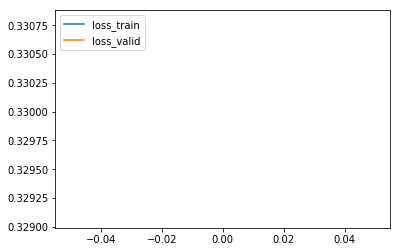

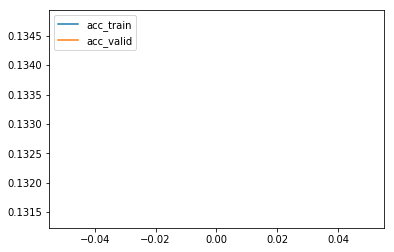

------ Training: 1 ------
Loss train: 0.330267, accuracy train: 0.158764
Loss valid: 0.328552, accuracy valid: 0.155000


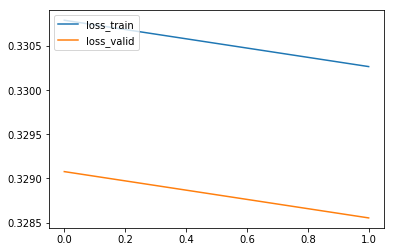

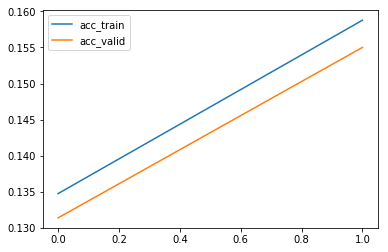

------ Training: 2 ------
Loss train: 0.329583, accuracy train: 0.176982
Loss valid: 0.327877, accuracy valid: 0.175200


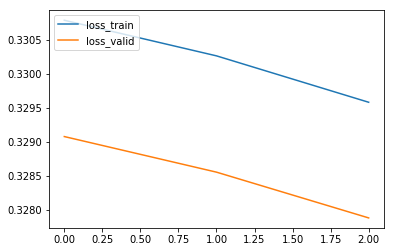

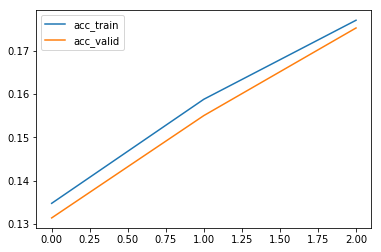

------ Training: 3 ------
Loss train: 0.329059, accuracy train: 0.193727
Loss valid: 0.327370, accuracy valid: 0.193800


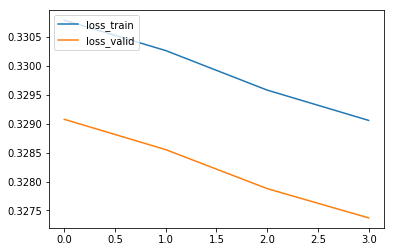

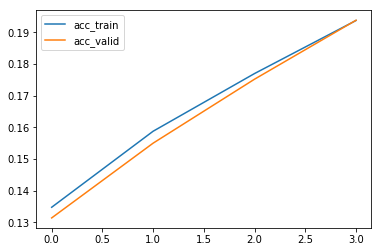

------ Training: 4 ------
Loss train: 0.328627, accuracy train: 0.212418
Loss valid: 0.326966, accuracy valid: 0.214400


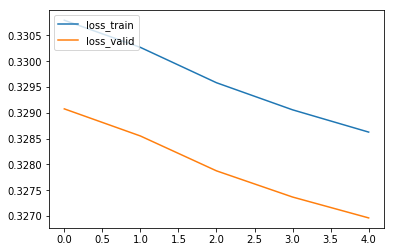

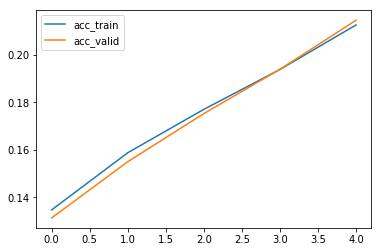

------ Training: 5 ------
Loss train: 0.328182, accuracy train: 0.233382
Loss valid: 0.326555, accuracy valid: 0.237200


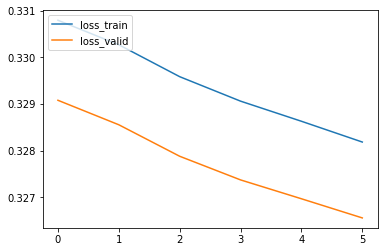

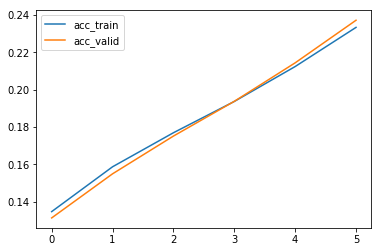

------ Training: 6 ------
Loss train: 0.327657, accuracy train: 0.258891
Loss valid: 0.326067, accuracy valid: 0.260600


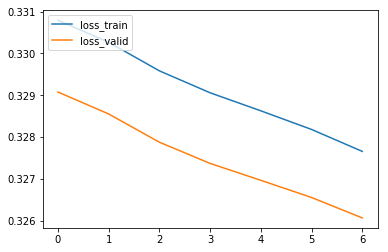

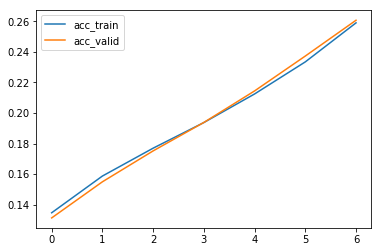

------ Training: 7 ------
Loss train: 0.327011, accuracy train: 0.288782
Loss valid: 0.325460, accuracy valid: 0.292000


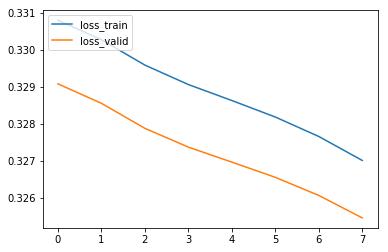

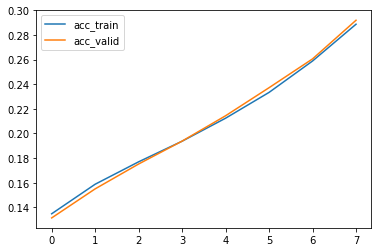

------ Training: 8 ------
Loss train: 0.326227, accuracy train: 0.323945
Loss valid: 0.324718, accuracy valid: 0.328800


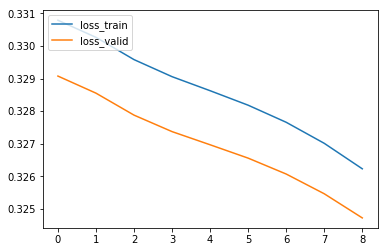

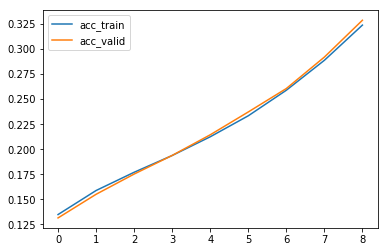

------ Training: 9 ------
Loss train: 0.325309, accuracy train: 0.359200
Loss valid: 0.323841, accuracy valid: 0.364000


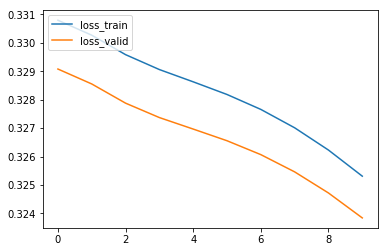

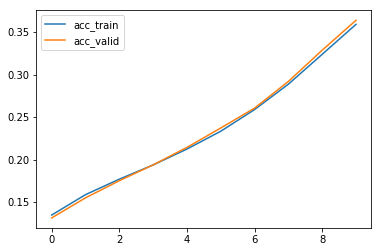

------ Training: 10 ------
Loss train: 0.324276, accuracy train: 0.395182
Loss valid: 0.322846, accuracy valid: 0.394200


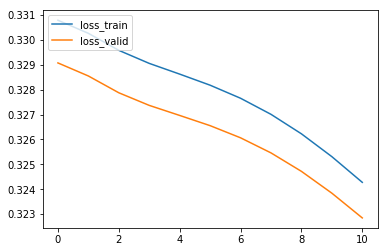

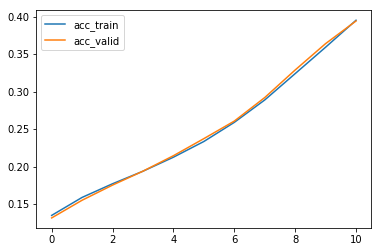

------ Training: 11 ------
Loss train: 0.323159, accuracy train: 0.430200
Loss valid: 0.321761, accuracy valid: 0.430000


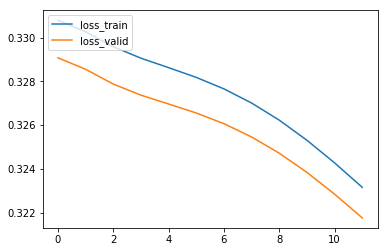

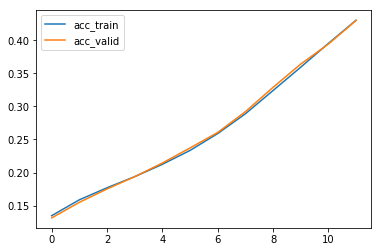

------ Training: 12 ------
Loss train: 0.321993, accuracy train: 0.463909
Loss valid: 0.320625, accuracy valid: 0.464800


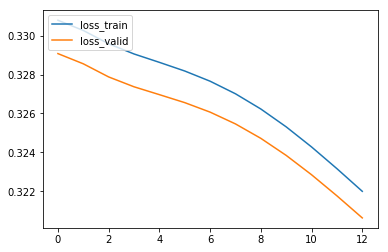

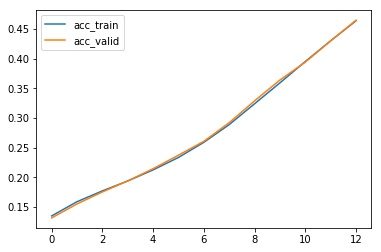

------ Training: 13 ------
Loss train: 0.320816, accuracy train: 0.494364
Loss valid: 0.319472, accuracy valid: 0.498200


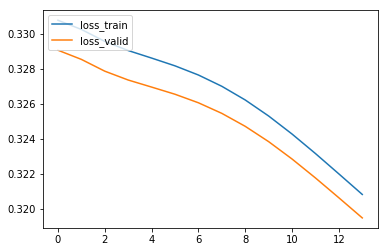

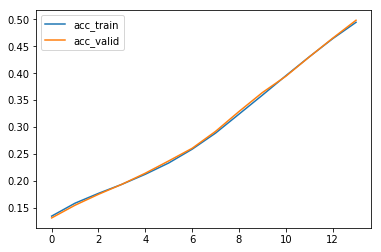

------ Training: 14 ------
Loss train: 0.319666, accuracy train: 0.522564
Loss valid: 0.318342, accuracy valid: 0.526400


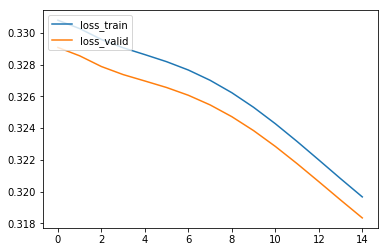

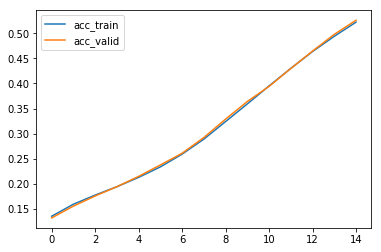

------ Training: 15 ------
Loss train: 0.318569, accuracy train: 0.549127
Loss valid: 0.317259, accuracy valid: 0.550200


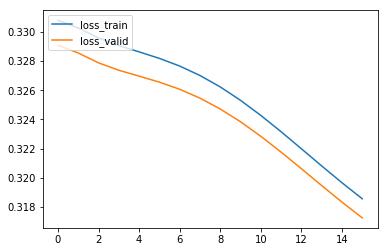

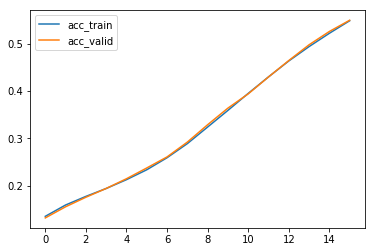

------ Training: 16 ------
Loss train: 0.317546, accuracy train: 0.571273
Loss valid: 0.316246, accuracy valid: 0.573800


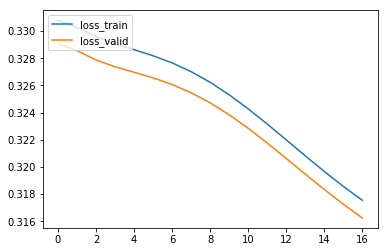

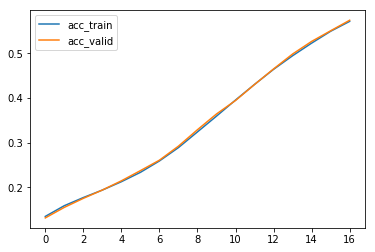

------ Training: 17 ------
Loss train: 0.316607, accuracy train: 0.592691
Loss valid: 0.315316, accuracy valid: 0.598000


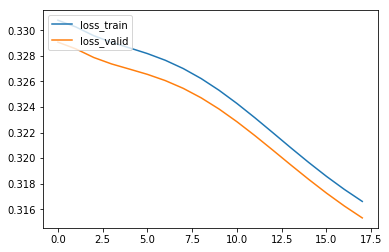

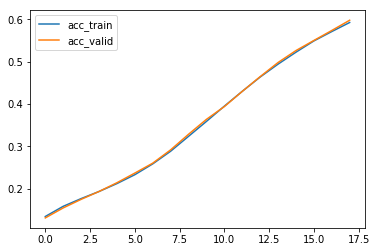

------ Training: 18 ------
Loss train: 0.315760, accuracy train: 0.610273
Loss valid: 0.314473, accuracy valid: 0.616000


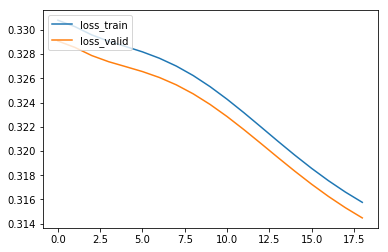

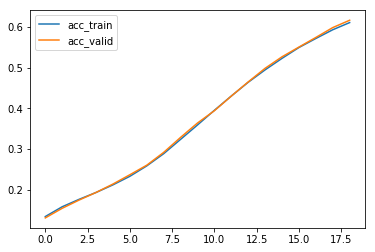

------ Training: 19 ------
Loss train: 0.315002, accuracy train: 0.625564
Loss valid: 0.313720, accuracy valid: 0.628400


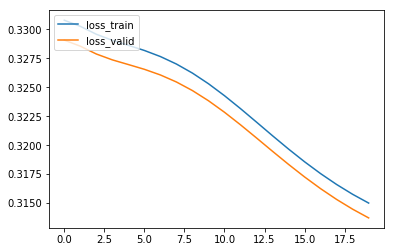

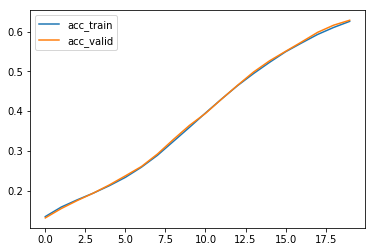

------ Training: 20 ------
Loss train: 0.314331, accuracy train: 0.638455
Loss valid: 0.313050, accuracy valid: 0.640400


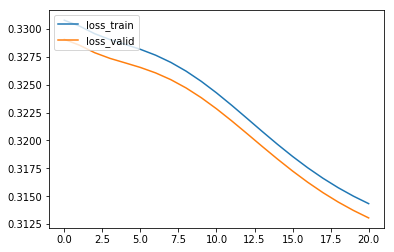

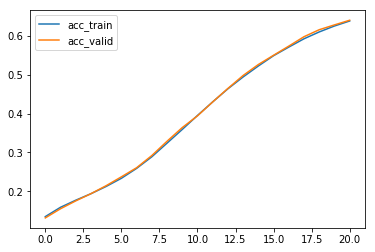

------ Training: 21 ------
Loss train: 0.313741, accuracy train: 0.650109
Loss valid: 0.312458, accuracy valid: 0.654200


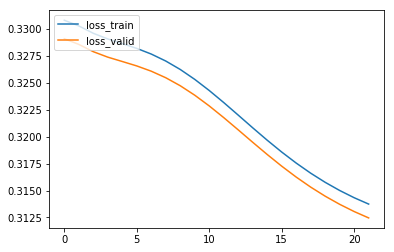

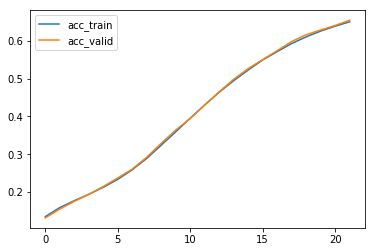

------ Training: 22 ------
Loss train: 0.313225, accuracy train: 0.660273
Loss valid: 0.311936, accuracy valid: 0.663400


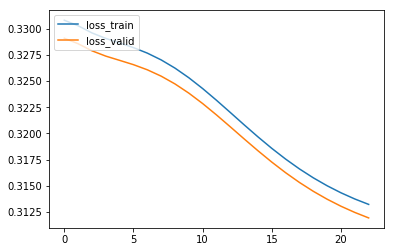

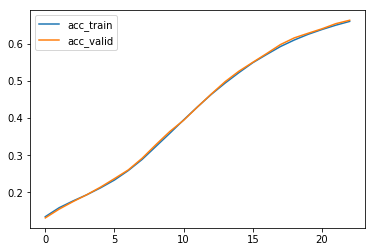

------ Training: 23 ------
Loss train: 0.312774, accuracy train: 0.668327
Loss valid: 0.311478, accuracy valid: 0.674400


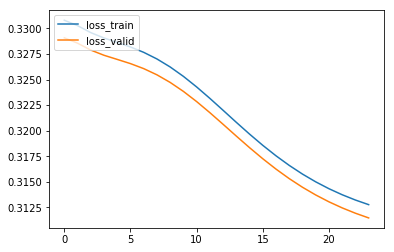

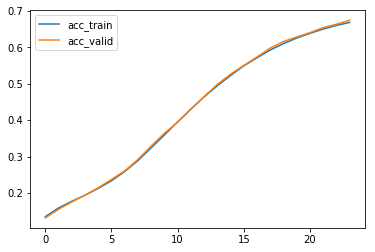

------ Training: 24 ------
Loss train: 0.312380, accuracy train: 0.676164
Loss valid: 0.311078, accuracy valid: 0.681600


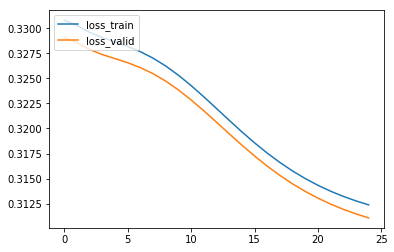

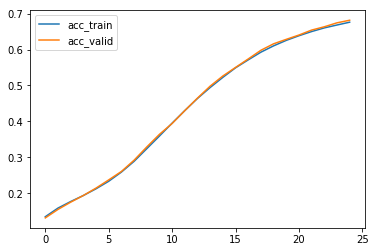

------ Training: 25 ------
Loss train: 0.312038, accuracy train: 0.683182
Loss valid: 0.310728, accuracy valid: 0.687400


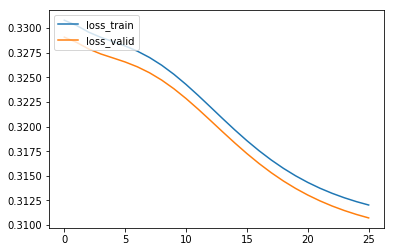

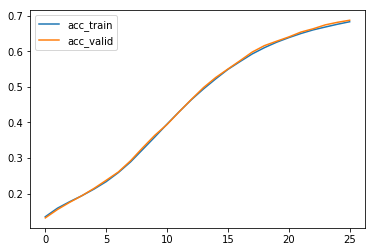

------ Training: 26 ------
Loss train: 0.311738, accuracy train: 0.688600
Loss valid: 0.310423, accuracy valid: 0.694400


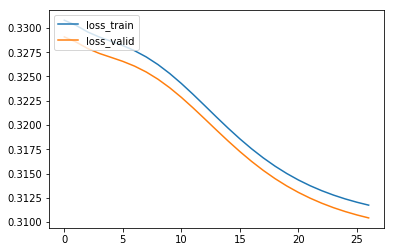

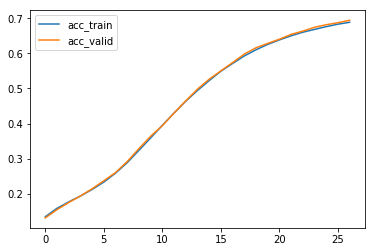

------ Training: 27 ------
Loss train: 0.311479, accuracy train: 0.693109
Loss valid: 0.310158, accuracy valid: 0.699200


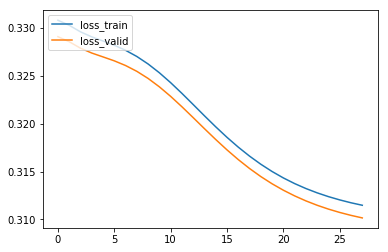

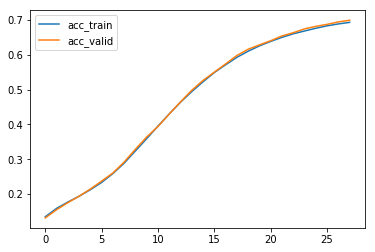

------ Training: 28 ------
Loss train: 0.311253, accuracy train: 0.697109
Loss valid: 0.309925, accuracy valid: 0.704000


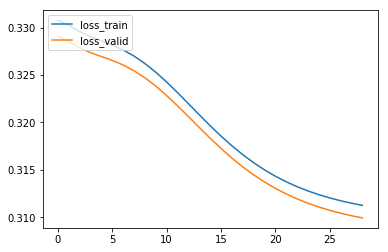

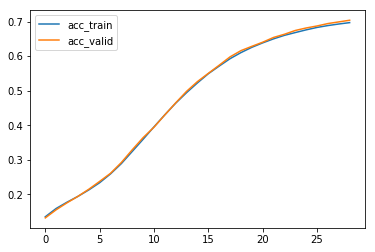

------ Training: 29 ------
Loss train: 0.311055, accuracy train: 0.700836
Loss valid: 0.309722, accuracy valid: 0.708000


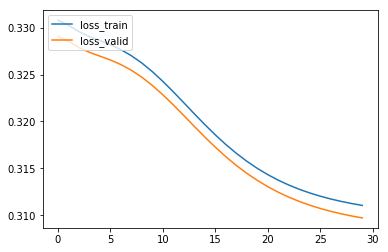

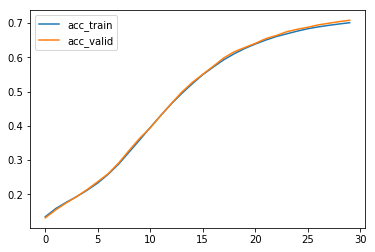

------ Training: 30 ------
Loss train: 0.310881, accuracy train: 0.704236
Loss valid: 0.309546, accuracy valid: 0.713000


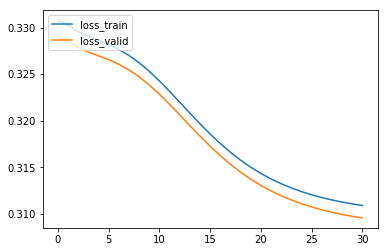

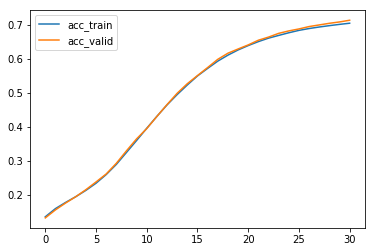

------ Training: 31 ------
Loss train: 0.310730, accuracy train: 0.706945
Loss valid: 0.309390, accuracy valid: 0.715800


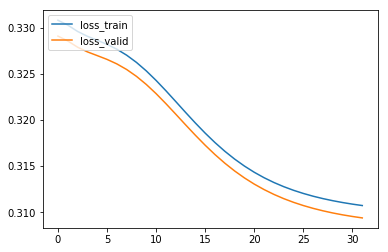

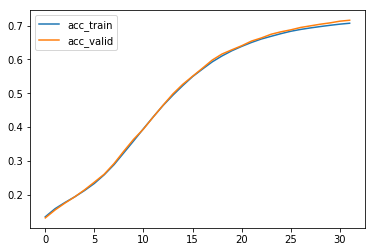

------ Training: 32 ------
Loss train: 0.310597, accuracy train: 0.709236
Loss valid: 0.309254, accuracy valid: 0.719800


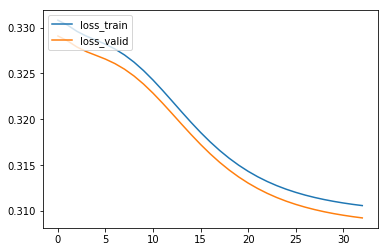

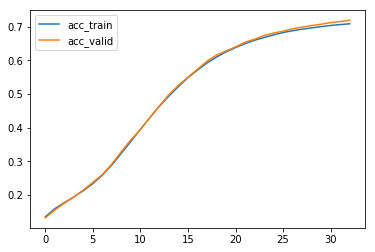

------ Training: 33 ------
Loss train: 0.310480, accuracy train: 0.710982
Loss valid: 0.309135, accuracy valid: 0.723200


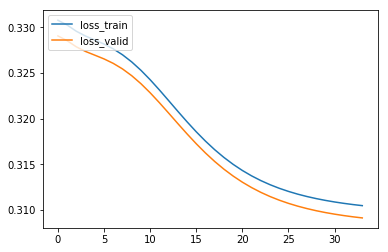

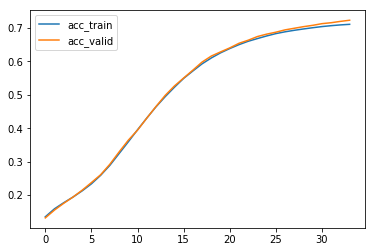

------ Training: 34 ------
Loss train: 0.310375, accuracy train: 0.713145
Loss valid: 0.309031, accuracy valid: 0.724200


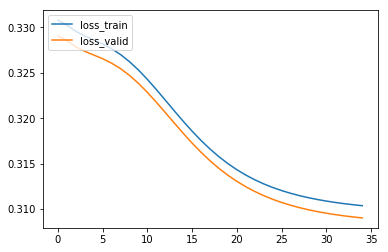

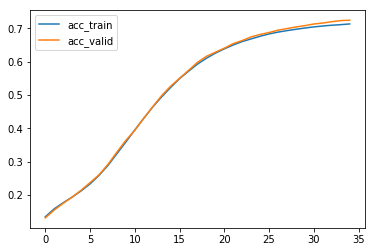

------ Training: 35 ------
Loss train: 0.310285, accuracy train: 0.714745
Loss valid: 0.308940, accuracy valid: 0.725600


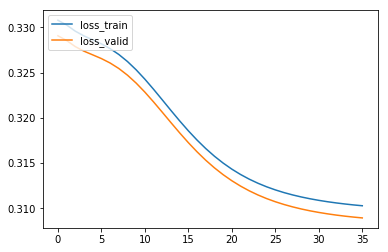

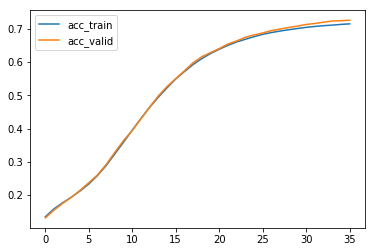

------ Training: 36 ------
Loss train: 0.310204, accuracy train: 0.716055
Loss valid: 0.308859, accuracy valid: 0.727800


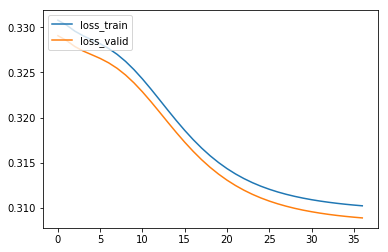

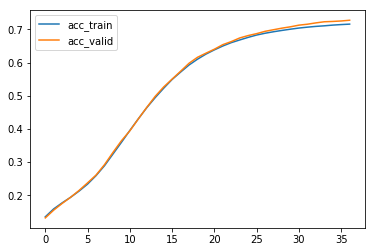

------ Training: 37 ------
Loss train: 0.310132, accuracy train: 0.717273
Loss valid: 0.308789, accuracy valid: 0.729000


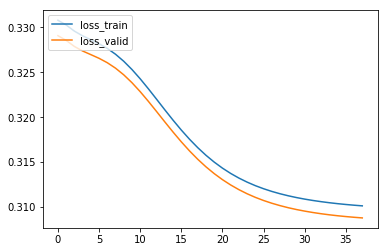

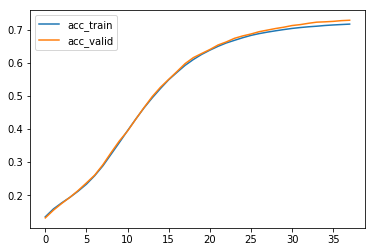

------ Training: 38 ------
Loss train: 0.310068, accuracy train: 0.718655
Loss valid: 0.308727, accuracy valid: 0.730000


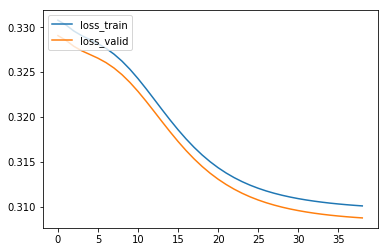

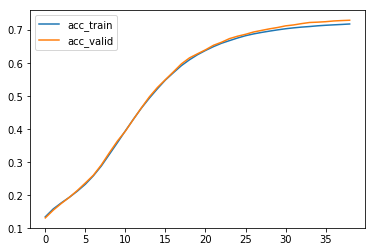

------ Training: 39 ------
Loss train: 0.310010, accuracy train: 0.719982
Loss valid: 0.308672, accuracy valid: 0.731000


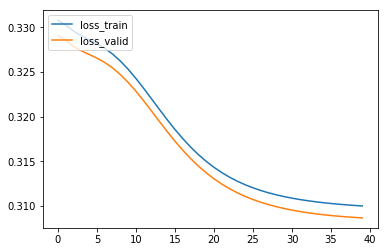

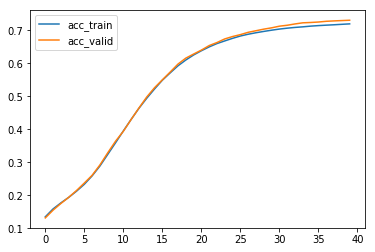

------ Training: 40 ------
Loss train: 0.309959, accuracy train: 0.721400
Loss valid: 0.308624, accuracy valid: 0.731600


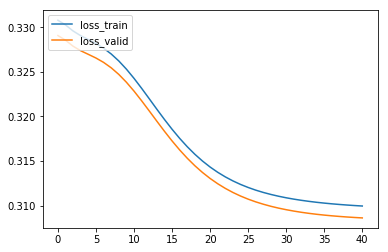

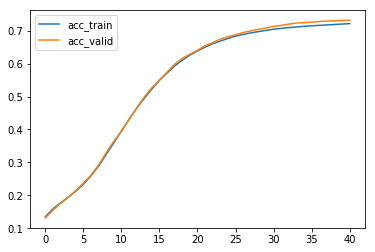

------ Training: 41 ------
Loss train: 0.309912, accuracy train: 0.722309
Loss valid: 0.308581, accuracy valid: 0.732800


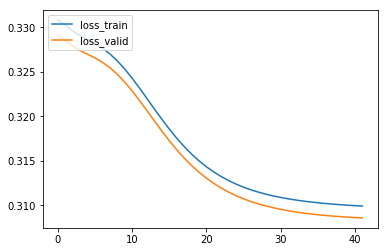

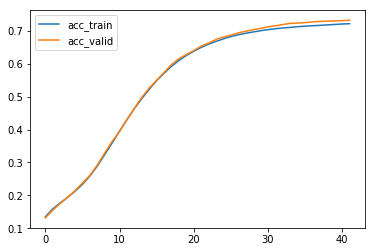

------ Training: 42 ------
Loss train: 0.309870, accuracy train: 0.722891
Loss valid: 0.308543, accuracy valid: 0.733200


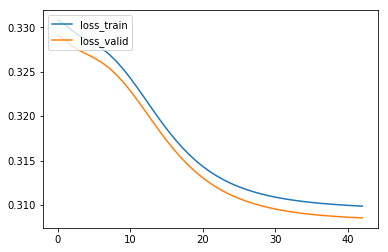

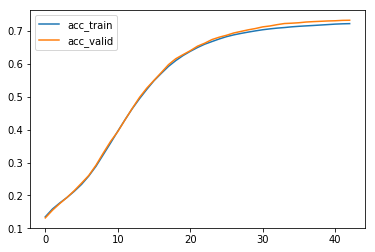

------ Training: 43 ------
Loss train: 0.309832, accuracy train: 0.723655
Loss valid: 0.308509, accuracy valid: 0.734000


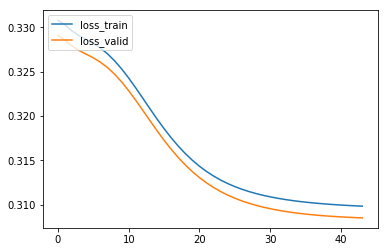

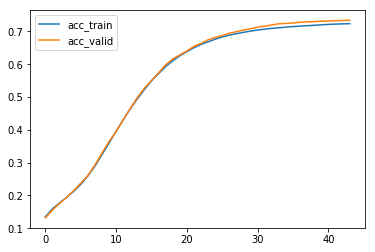

------ Training: 44 ------
Loss train: 0.309797, accuracy train: 0.724473
Loss valid: 0.308478, accuracy valid: 0.734200


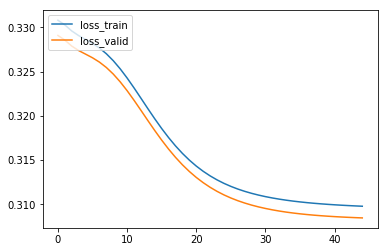

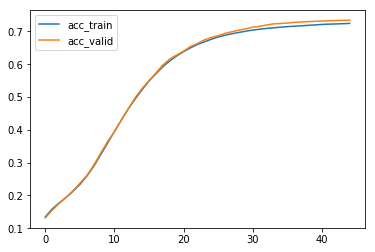

------ Training: 45 ------
Loss train: 0.309765, accuracy train: 0.725164
Loss valid: 0.308451, accuracy valid: 0.735400


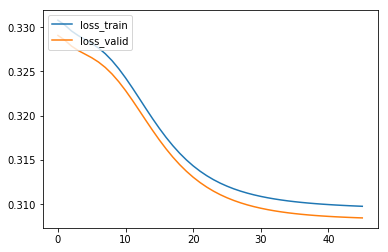

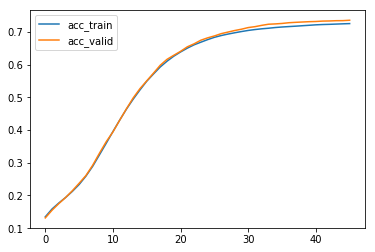

------ Training: 46 ------
Loss train: 0.309735, accuracy train: 0.726182
Loss valid: 0.308427, accuracy valid: 0.736400


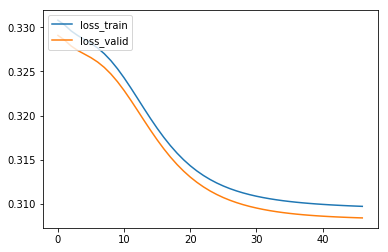

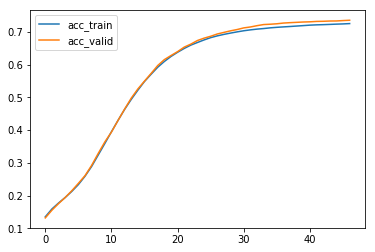

------ Training: 47 ------
Loss train: 0.309709, accuracy train: 0.726655
Loss valid: 0.308405, accuracy valid: 0.737000


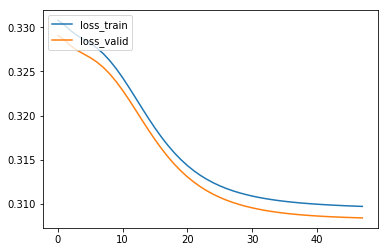

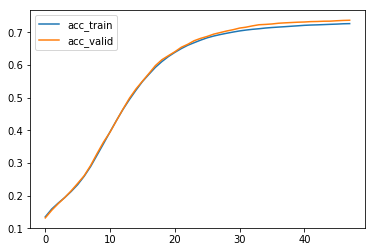

------ Training: 48 ------
Loss train: 0.309683, accuracy train: 0.727327
Loss valid: 0.308385, accuracy valid: 0.737200


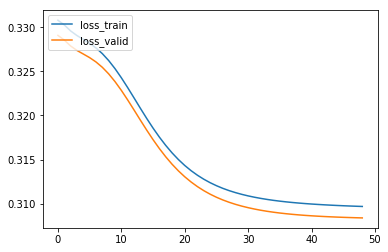

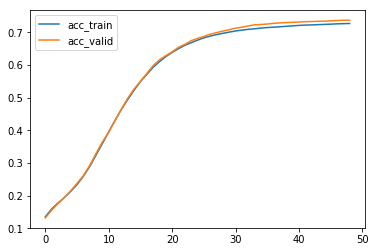

------ Training: 49 ------
Loss train: 0.309659, accuracy train: 0.728018
Loss valid: 0.308367, accuracy valid: 0.737800


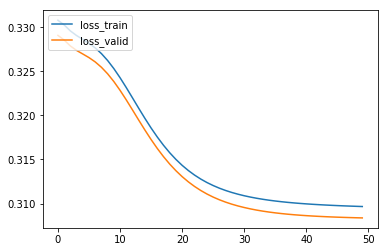

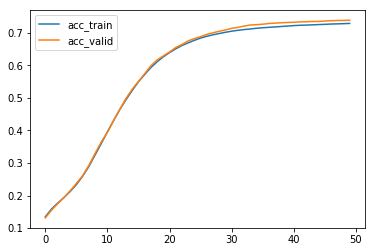

Loss valid: 0.316769, accuracy valid: 0.730600


In [7]:
# parameters 
n_inputs = 28*28
n_outputs = 10
n_hiddens = 100 
n_batches = np.shape(trainX)[1]
train_epochs = 50 
warm_epochs = 10 
n_layers = 2

# these parameters are used in the paper 
# theoretically can converge with any hyperparameters
# can tune these to check the effect
beta = 1.0
gamma = 10.0

model = ADMM_NN(n_inputs, n_hiddens, n_outputs, n_batches, n_layers)

model.warming(trainX, trainY, warm_epochs, beta, gamma)

list_loss_train = []
list_loss_valid = []
list_accuracy_train = []
list_accuracy_valid = []

for i in range(train_epochs):
    print("------ Training: {:d} ------".format(i))
    loss_train, accuracy_train = model.fit(trainX, trainY, beta, gamma)
    loss_valid, accuracy_valid = model.evaluate(validX, validY)

    print("Loss train: %3f, accuracy train: %3f" % (np.array(loss_train), np.array(accuracy_train)))
    print("Loss valid: %3f, accuracy valid: %3f" % (np.array(loss_valid), np.array(accuracy_valid)))

    list_loss_train.append(np.array(loss_train))
    list_loss_valid.append(np.array(loss_valid))
    list_accuracy_train.append(np.array(accuracy_train))
    list_accuracy_valid.append(np.array(accuracy_valid))

    # Drawing loss, accuracy of train and valid
    model.drawcurve(list_loss_train, list_loss_valid, 'loss_train', 'loss_valid')
    model.drawcurve(list_accuracy_train, list_accuracy_valid, 'acc_train', 'acc_valid')


# Evaluate model on test set
loss, accuracy = model.evaluate(testX, testY)
print("Loss test: %3f, accuracy test: %3f" % (loss, accuracy))



------ Warming: 0 ------
------ Warming: 1 ------
------ Warming: 2 ------
------ Warming: 3 ------
------ Warming: 4 ------
------ Warming: 5 ------
------ Warming: 6 ------
------ Warming: 7 ------
------ Warming: 8 ------
------ Warming: 9 ------
------ Warming: 10 ------
------ Warming: 11 ------
------ Warming: 12 ------
------ Warming: 13 ------
------ Warming: 14 ------
------ Warming: 15 ------
------ Warming: 16 ------
------ Warming: 17 ------
------ Warming: 18 ------
------ Warming: 19 ------
------ Warming: 20 ------
------ Warming: 21 ------
------ Warming: 22 ------
------ Warming: 23 ------
------ Warming: 24 ------
------ Warming: 25 ------
------ Warming: 26 ------
------ Warming: 27 ------
------ Warming: 28 ------
------ Warming: 29 ------
------ Warming: 30 ------
------ Warming: 31 ------
------ Warming: 32 ------
------ Warming: 33 ------
------ Warming: 34 ------
------ Warming: 35 ------
------ Warming: 36 ------
------ Warming: 37 ------
------ Warming: 38 ---

Loss train: 0.311842, accuracy train: 0.636055
Loss valid: 0.312038, accuracy valid: 0.656200
------ Training: 56 ------
Loss train: 0.311805, accuracy train: 0.636600
Loss valid: 0.312028, accuracy valid: 0.657000
------ Training: 57 ------
Loss train: 0.311773, accuracy train: 0.637273
Loss valid: 0.312024, accuracy valid: 0.658000
------ Training: 58 ------
Loss train: 0.311738, accuracy train: 0.638073
Loss valid: 0.312020, accuracy valid: 0.658600
------ Training: 59 ------
Loss train: 0.311708, accuracy train: 0.639164
Loss valid: 0.312020, accuracy valid: 0.659200
------ Training: 60 ------
Loss train: 0.311677, accuracy train: 0.639800
Loss valid: 0.312022, accuracy valid: 0.660000
------ Training: 61 ------
Loss train: 0.311647, accuracy train: 0.640582
Loss valid: 0.312025, accuracy valid: 0.660800
------ Training: 62 ------
Loss train: 0.311616, accuracy train: 0.641418
Loss valid: 0.312031, accuracy valid: 0.661600
------ Training: 63 ------
Loss train: 0.311584, accuracy t

Loss train: 0.310739, accuracy train: 0.663873
Loss valid: 0.317953, accuracy valid: 0.676000
------ Training: 124 ------
Loss train: 0.310727, accuracy train: 0.664309
Loss valid: 0.318125, accuracy valid: 0.676200
------ Training: 125 ------
Loss train: 0.310718, accuracy train: 0.664418
Loss valid: 0.318304, accuracy valid: 0.676800
------ Training: 126 ------
Loss train: 0.310696, accuracy train: 0.664564
Loss valid: 0.318474, accuracy valid: 0.676600
------ Training: 127 ------
Loss train: 0.310691, accuracy train: 0.664636
Loss valid: 0.318665, accuracy valid: 0.677200
------ Training: 128 ------
Loss train: 0.310680, accuracy train: 0.664945
Loss valid: 0.318855, accuracy valid: 0.677000
------ Training: 129 ------
Loss train: 0.310678, accuracy train: 0.665182
Loss valid: 0.319055, accuracy valid: 0.677400
------ Training: 130 ------
Loss train: 0.310667, accuracy train: 0.665218
Loss valid: 0.319253, accuracy valid: 0.677200
------ Training: 131 ------
Loss train: 0.310658, ac

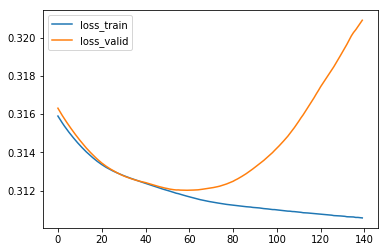

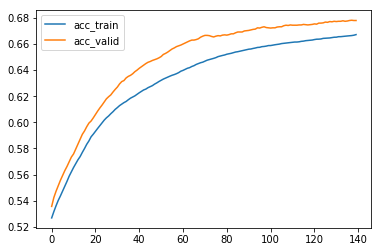

-------- Result --------
N layers: 4, Test Accuracy: 0.671500
------ Warming: 0 ------
------ Warming: 1 ------
------ Warming: 2 ------
------ Warming: 3 ------
------ Warming: 4 ------
------ Warming: 5 ------
------ Warming: 6 ------
------ Warming: 7 ------
------ Warming: 8 ------
------ Warming: 9 ------
------ Warming: 10 ------
------ Warming: 11 ------
------ Warming: 12 ------
------ Warming: 13 ------
------ Warming: 14 ------
------ Warming: 15 ------
------ Warming: 16 ------
------ Warming: 17 ------
------ Warming: 18 ------
------ Warming: 19 ------
------ Warming: 20 ------
------ Warming: 21 ------
------ Warming: 22 ------
------ Warming: 23 ------
------ Warming: 24 ------
------ Warming: 25 ------
------ Warming: 26 ------
------ Warming: 27 ------
------ Warming: 28 ------
------ Warming: 29 ------
------ Warming: 30 ------
------ Warming: 31 ------
------ Warming: 32 ------
------ Warming: 33 ------
------ Warming: 34 ------
------ Warming: 35 ------
------ Warmi

Loss train: 0.325847, accuracy train: 0.235418
Loss valid: 0.441756, accuracy valid: 0.227400
------ Training: 49 ------
Loss train: 0.325841, accuracy train: 0.235509
Loss valid: 0.449621, accuracy valid: 0.228000
------ Training: 50 ------
Loss train: 0.325836, accuracy train: 0.235618
Loss valid: 0.458037, accuracy valid: 0.228200
------ Training: 51 ------
Loss train: 0.325838, accuracy train: 0.235509
Loss valid: 0.467092, accuracy valid: 0.229000
------ Training: 52 ------
Loss train: 0.325834, accuracy train: 0.235673
Loss valid: 0.475388, accuracy valid: 0.228800
------ Training: 53 ------
Loss train: 0.325833, accuracy train: 0.235745
Loss valid: 0.483600, accuracy valid: 0.229600
------ Training: 54 ------
Loss train: 0.325830, accuracy train: 0.235964
Loss valid: 0.492366, accuracy valid: 0.229000
------ Training: 55 ------
Loss train: 0.325829, accuracy train: 0.236109
Loss valid: 0.502273, accuracy valid: 0.229800
------ Training: 56 ------
Loss train: 0.325826, accuracy t

Loss train: 0.325732, accuracy train: 0.243473
Loss valid: 1.607912, accuracy valid: 0.238400
------ Training: 117 ------
Loss train: 0.325727, accuracy train: 0.243636
Loss valid: 1.654194, accuracy valid: 0.237800
------ Training: 118 ------
Loss train: 0.325730, accuracy train: 0.243582
Loss valid: 1.694174, accuracy valid: 0.238400
------ Training: 119 ------
Loss train: 0.325738, accuracy train: 0.243618
Loss valid: 1.734356, accuracy valid: 0.238800
------ Training: 120 ------
Loss train: 0.325741, accuracy train: 0.243891
Loss valid: 1.779672, accuracy valid: 0.239200
------ Training: 121 ------
Loss train: 0.325744, accuracy train: 0.243818
Loss valid: 1.829270, accuracy valid: 0.238800
------ Training: 122 ------
Loss train: 0.325737, accuracy train: 0.244109
Loss valid: 1.889065, accuracy valid: 0.238600
------ Training: 123 ------
Loss train: 0.325732, accuracy train: 0.244255
Loss valid: 1.956876, accuracy valid: 0.238800
------ Training: 124 ------
Loss train: 0.325726, ac

Loss train: 0.325666, accuracy train: 0.247945
Loss valid: 7.430273, accuracy valid: 0.241600
------ Training: 185 ------
Loss train: 0.325660, accuracy train: 0.248036
Loss valid: 7.426146, accuracy valid: 0.241000
------ Training: 186 ------
Loss train: 0.325670, accuracy train: 0.247800
Loss valid: 7.467300, accuracy valid: 0.240800
------ Training: 187 ------
Loss train: 0.325680, accuracy train: 0.248018
Loss valid: 7.532186, accuracy valid: 0.241200
------ Training: 188 ------
Loss train: 0.325668, accuracy train: 0.248291
Loss valid: 7.634628, accuracy valid: 0.241400
------ Training: 189 ------
Loss train: 0.325666, accuracy train: 0.248327
Loss valid: 7.761579, accuracy valid: 0.241600
------ Training: 190 ------
Loss train: 0.325672, accuracy train: 0.248018
Loss valid: 7.890816, accuracy valid: 0.241200
------ Training: 191 ------
Loss train: 0.325672, accuracy train: 0.248818
Loss valid: 8.024837, accuracy valid: 0.241400
------ Training: 192 ------
Loss train: 0.325683, ac

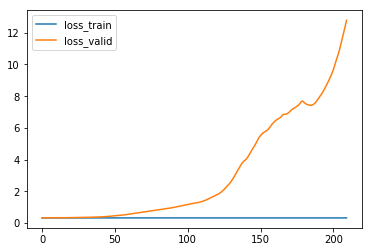

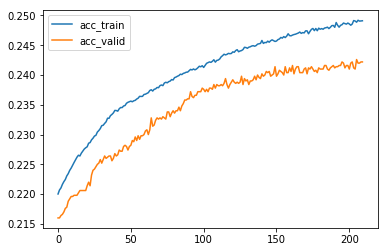

-------- Result --------
N layers: 6, Test Accuracy: 0.251600
------ Warming: 0 ------
------ Warming: 1 ------
------ Warming: 2 ------
------ Warming: 3 ------
------ Warming: 4 ------
------ Warming: 5 ------
------ Warming: 6 ------
------ Warming: 7 ------
------ Warming: 8 ------
------ Warming: 9 ------
------ Warming: 10 ------
------ Warming: 11 ------
------ Warming: 12 ------
------ Warming: 13 ------
------ Warming: 14 ------
------ Warming: 15 ------
------ Warming: 16 ------
------ Warming: 17 ------
------ Warming: 18 ------
------ Warming: 19 ------
------ Warming: 20 ------
------ Warming: 21 ------
------ Warming: 22 ------
------ Warming: 23 ------
------ Warming: 24 ------
------ Warming: 25 ------
------ Warming: 26 ------
------ Warming: 27 ------
------ Warming: 28 ------
------ Warming: 29 ------
------ Warming: 30 ------
------ Warming: 31 ------
------ Warming: 32 ------
------ Warming: 33 ------
------ Warming: 34 ------
------ Warming: 35 ------
------ Warmi

Loss train: 0.327014, accuracy train: 0.154400
Loss valid: 1.817161, accuracy valid: 0.146800
------ Training: 43 ------
Loss train: 0.327014, accuracy train: 0.154545
Loss valid: 1.677929, accuracy valid: 0.147200
------ Training: 44 ------
Loss train: 0.327014, accuracy train: 0.154745
Loss valid: 1.641519, accuracy valid: 0.146600
------ Training: 45 ------
Loss train: 0.327010, accuracy train: 0.154709
Loss valid: 1.676898, accuracy valid: 0.147000
------ Training: 46 ------
Loss train: 0.327012, accuracy train: 0.154709
Loss valid: 1.791650, accuracy valid: 0.146200
------ Training: 47 ------
Loss train: 0.327012, accuracy train: 0.154982
Loss valid: 1.985729, accuracy valid: 0.146800
------ Training: 48 ------
Loss train: 0.327003, accuracy train: 0.155073
Loss valid: 2.129811, accuracy valid: 0.147000
------ Training: 49 ------
Loss train: 0.327003, accuracy train: 0.154982
Loss valid: 2.093306, accuracy valid: 0.146600
------ Training: 50 ------
Loss train: 0.327000, accuracy t

Loss train: 0.326985, accuracy train: 0.158000
Loss valid: 110.528603, accuracy valid: 0.149600
------ Training: 111 ------
Loss train: 0.326990, accuracy train: 0.157855
Loss valid: 116.020729, accuracy valid: 0.147200
------ Training: 112 ------
Loss train: 0.326972, accuracy train: 0.157945
Loss valid: 124.282967, accuracy valid: 0.148800
------ Training: 113 ------
Loss train: 0.326977, accuracy train: 0.157836
Loss valid: 133.507034, accuracy valid: 0.147400
------ Training: 114 ------
Loss train: 0.326980, accuracy train: 0.157836
Loss valid: 143.916168, accuracy valid: 0.147800
------ Training: 115 ------
Loss train: 0.326978, accuracy train: 0.157909
Loss valid: 155.838104, accuracy valid: 0.148000
------ Training: 116 ------
Loss train: 0.326970, accuracy train: 0.158109
Loss valid: 168.981934, accuracy valid: 0.148400
------ Training: 117 ------
Loss train: 0.326992, accuracy train: 0.158236
Loss valid: 184.204361, accuracy valid: 0.148400
------ Training: 118 ------
Loss tra

Loss train: 0.326982, accuracy train: 0.158273
Loss valid: 1950.278442, accuracy valid: 0.149200
------ Training: 177 ------
Loss train: 0.326951, accuracy train: 0.158818
Loss valid: 2008.984741, accuracy valid: 0.149200
------ Training: 178 ------
Loss train: 0.326964, accuracy train: 0.159200
Loss valid: 2069.039307, accuracy valid: 0.149400
------ Training: 179 ------
Loss train: 0.326974, accuracy train: 0.158909
Loss valid: 2127.310791, accuracy valid: 0.149400
------ Training: 180 ------
Loss train: 0.326974, accuracy train: 0.158982
Loss valid: 2188.722656, accuracy valid: 0.149000
------ Training: 181 ------
Loss train: 0.326943, accuracy train: 0.158364
Loss valid: 2249.574707, accuracy valid: 0.149800
------ Training: 182 ------
Loss train: 0.326955, accuracy train: 0.158400
Loss valid: 2303.050537, accuracy valid: 0.149200
------ Training: 183 ------
Loss train: 0.326950, accuracy train: 0.158855
Loss valid: 2357.766113, accuracy valid: 0.149000
------ Training: 184 ------


Loss train: 0.326936, accuracy train: 0.158818
Loss valid: 11977.421875, accuracy valid: 0.151000
------ Training: 243 ------
Loss train: 0.326936, accuracy train: 0.158836
Loss valid: 12242.867188, accuracy valid: 0.150800
------ Training: 244 ------
Loss train: 0.326961, accuracy train: 0.159945
Loss valid: 12561.245117, accuracy valid: 0.150200
------ Training: 245 ------
Loss train: 0.326954, accuracy train: 0.159091
Loss valid: 12848.903320, accuracy valid: 0.152000
------ Training: 246 ------
Loss train: 0.326938, accuracy train: 0.159364
Loss valid: 13163.181641, accuracy valid: 0.150800
------ Training: 247 ------
Loss train: 0.326946, accuracy train: 0.159109
Loss valid: 13483.323242, accuracy valid: 0.150600
------ Training: 248 ------
Loss train: 0.326972, accuracy train: 0.159055
Loss valid: 13799.098633, accuracy valid: 0.150400
------ Training: 249 ------
Loss train: 0.326933, accuracy train: 0.159309
Loss valid: 14110.351562, accuracy valid: 0.150800
------ Training: 250

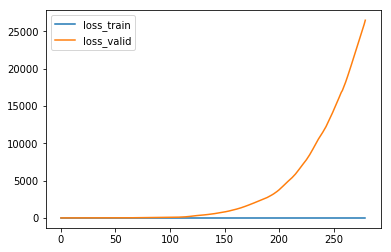

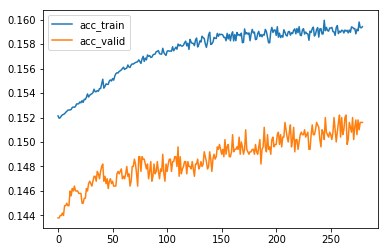

-------- Result --------
N layers: 8, Test Accuracy: 0.156400
------ Warming: 0 ------
------ Warming: 1 ------
------ Warming: 2 ------
------ Warming: 3 ------
------ Warming: 4 ------
------ Warming: 5 ------
------ Warming: 6 ------
------ Warming: 7 ------
------ Warming: 8 ------
------ Warming: 9 ------
------ Warming: 10 ------
------ Warming: 11 ------
------ Warming: 12 ------
------ Warming: 13 ------
------ Warming: 14 ------
------ Warming: 15 ------
------ Warming: 16 ------
------ Warming: 17 ------
------ Warming: 18 ------
------ Warming: 19 ------
------ Warming: 20 ------
------ Warming: 21 ------
------ Warming: 22 ------
------ Warming: 23 ------
------ Warming: 24 ------
------ Warming: 25 ------
------ Warming: 26 ------
------ Warming: 27 ------
------ Warming: 28 ------
------ Warming: 29 ------
------ Warming: 30 ------
------ Warming: 31 ------
------ Warming: 32 ------
------ Warming: 33 ------
------ Warming: 34 ------
------ Warming: 35 ------
------ Warmi

KeyboardInterrupt: 

In [18]:
# parameters 
n_inputs = 28*28
n_outputs = 10
n_hiddens = 100 
n_batches = np.shape(trainX)[1]
train_epochs = 50 
warm_epochs = 30  #warming is very helpful
# n_layers = 2

# these parameters are used in the paper 
# theoretically can converge with any hyperparameters
# can tune these to check the effect
beta = 1.0
gamma = 10.0

for n_layers in [4, 6, 8, 10, 12]:
    warm_epochs = 15 * n_layers
    train_epochs = 35 * n_layers
    
    model = ADMM_NN(n_inputs, n_hiddens, n_outputs, n_batches, n_layers)

    model.warming(trainX, trainY, warm_epochs, beta, gamma)

    list_loss_train = []
    list_loss_valid = []
    list_accuracy_train = []
    list_accuracy_valid = []

    for i in range(train_epochs):
        print("------ Training: {:d} ------".format(i))
        loss_train, accuracy_train = model.fit(trainX, trainY, beta, gamma)
        loss_valid, accuracy_valid = model.evaluate(validX, validY)

        print("Loss train: %3f, accuracy train: %3f" % (np.array(loss_train), np.array(accuracy_train)))
        print("Loss valid: %3f, accuracy valid: %3f" % (np.array(loss_valid), np.array(accuracy_valid)))

        list_loss_train.append(np.array(loss_train))
        list_loss_valid.append(np.array(loss_valid))
        list_accuracy_train.append(np.array(accuracy_train))
        list_accuracy_valid.append(np.array(accuracy_valid))

    # Drawing loss, accuracy of train and valid
    model.drawcurve(list_loss_train, list_loss_valid, 'loss_train', 'loss_valid')
    model.drawcurve(list_accuracy_train, list_accuracy_valid, 'acc_train', 'acc_valid')


    # Evaluate model on test set
    loss, accuracy = model.evaluate(testX, testY)
    print("-------- Result --------")
    print("N layers: %d, Test Accuracy: %3f" % (n_layers, accuracy))

In [20]:
loss, accuracy = model.evaluate(testX, testY)
print("-------- Result --------")
print("N layers: %d, Test Accuracy: %3f" % (n_layers, accuracy))

-------- Result --------
N layers: 10, Test Accuracy: 0.123800


------ Warming: 0 ------
------ Warming: 1 ------
------ Warming: 2 ------
------ Warming: 3 ------
------ Warming: 4 ------
------ Warming: 5 ------
------ Warming: 6 ------
------ Warming: 7 ------
------ Warming: 8 ------
------ Warming: 9 ------
------ Warming: 10 ------
------ Warming: 11 ------
------ Warming: 12 ------
------ Warming: 13 ------
------ Warming: 14 ------
------ Training: 0 ------
Loss train: 0.294118, accuracy train: 0.811527
Loss valid: 0.293329, accuracy valid: 0.813400
------ Training: 1 ------
Loss train: 0.287638, accuracy train: 0.829509
Loss valid: 0.286984, accuracy valid: 0.829400
------ Training: 2 ------
Loss train: 0.283869, accuracy train: 0.838436
Loss valid: 0.283175, accuracy valid: 0.837600
------ Training: 3 ------
Loss train: 0.281769, accuracy train: 0.843673
Loss valid: 0.280968, accuracy valid: 0.843200
------ Training: 4 ------
Loss train: 0.280877, accuracy train: 0.846127
Loss valid: 0.279986, accuracy valid: 0.845600
------ Training: 5 -

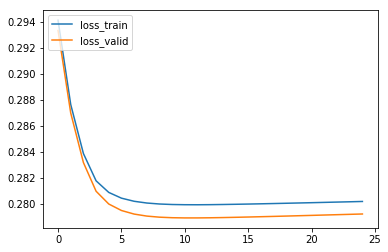

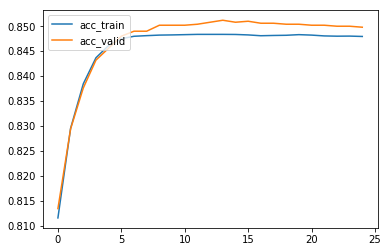

-------- Result --------
N layers: 1, Test Accuracy: 0.852300


In [3]:
# parameters 
n_inputs = 28*28
n_outputs = 10
n_hiddens = 100 
n_batches = np.shape(trainX)[1]
train_epochs = 50 
warm_epochs = 30  #warming is very helpful
# n_layers = 2

# these parameters are used in the paper 
# theoretically can converge with any hyperparameters
# can tune these to check the effect
beta = 1.0
gamma = 10.0
for n_layers in [1]:
    warm_epochs = 15 * n_layers
    train_epochs = 25 * n_layers
    
    model = ADMM_NN(n_inputs, n_hiddens, n_outputs, n_batches, n_layers)

    model.warming(trainX, trainY, warm_epochs, beta, gamma)

    list_loss_train = []
    list_loss_valid = []
    list_accuracy_train = []
    list_accuracy_valid = []

    for i in range(train_epochs):
        print("------ Training: {:d} ------".format(i))
        loss_train, accuracy_train = model.fit(trainX, trainY, beta, gamma)
        loss_valid, accuracy_valid = model.evaluate(validX, validY)

        print("Loss train: %3f, accuracy train: %3f" % (np.array(loss_train), np.array(accuracy_train)))
        print("Loss valid: %3f, accuracy valid: %3f" % (np.array(loss_valid), np.array(accuracy_valid)))

        list_loss_train.append(np.array(loss_train))
        list_loss_valid.append(np.array(loss_valid))
        list_accuracy_train.append(np.array(accuracy_train))
        list_accuracy_valid.append(np.array(accuracy_valid))

    # Drawing loss, accuracy of train and valid
    model.drawcurve(list_loss_train, list_loss_valid, 'loss_train', 'loss_valid')
    model.drawcurve(list_accuracy_train, list_accuracy_valid, 'acc_train', 'acc_valid')


    # Evaluate model on test set
    loss, accuracy = model.evaluate(testX, testY)
    print("-------- Result --------")
    print("N layers: %d, Test Accuracy: %3f" % (n_layers, accuracy))

In [22]:
loss, accuracy = model.evaluate(testX, testY)
print("-------- Result --------")
print("N layers: %d, Test Accuracy: %3f" % (n_layers, accuracy))

-------- Result --------
N layers: 12, Test Accuracy: 0.125000


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Trianing and validation loss')
plt.legend()

plt.show()